# Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, Bidirectional, GlobalMaxPool1D

%matplotlib inline
sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.4f' % x)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (1804874, 45)
Test shape :  (97320, 2)


# Preprocess

In [3]:
train['target'] = np.where(train['target'] >= 0.5, 1, 0)
train['comment_text'] = train['comment_text'].astype(str)
X_test = test['comment_text'].astype(str)

In [4]:
# Train/validation split
train_ids, val_ids = train_test_split(train['id'], test_size=0.2, random_state=2019)

train_df = pd.merge(train_ids.to_frame(), train)
validate_df = pd.merge(val_ids.to_frame(), train)
Y_train = train_df['target'].values
Y_val = validate_df['target'].values
X_train = train_df['comment_text']
X_val = validate_df['comment_text']

In [5]:
# Hyper parameters
maxlen = 150 # max number of words in a question to use
embed_size = 300 # how big is each word vector
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)

In [6]:
# Fill missing values
X_train = X_train.fillna("_na_").values
X_val = X_val.fillna("_na_").values
X_test = X_test.fillna("_na_").values

In [7]:
# Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [8]:
# Pad the sentences 
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Model

In [9]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = CuDNNGRU(64, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 300)          9000000   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 150, 64)           70272     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)  

In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, validation_data=(X_val, Y_val), callbacks=[es])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1443899 samples, validate on 360975 samples
Epoch 1/20
1443899/1443899 [==============================] - 84s 58us/step - loss: 0.1533 - acc: 0.9454 - val_loss: 0.1302 - val_acc: 0.9500
Epoch 2/20
1443899/1443899 [==============================] - 81s 56us/step - loss: 0.1268 - acc: 0.9514 - val_loss: 0.1288 - val_acc: 0.9504
Epoch 3/20
1443899/1443899 [==============================] - 81s 56us/step - loss: 0.1146 - acc: 0.9552 - val_loss: 0.1320 - val_acc: 0.9502
Epoch 4/20
1443899/1443899 [==============================] - 82s 56us/step - loss: 0.1003 - acc: 0.9602 - val_loss: 0.1407 - val_acc: 0.9484
Epoch 5/20
 323072/1443899 [=====>........................] - ETA: 58s - loss: 0.0773 - acc: 0.9692

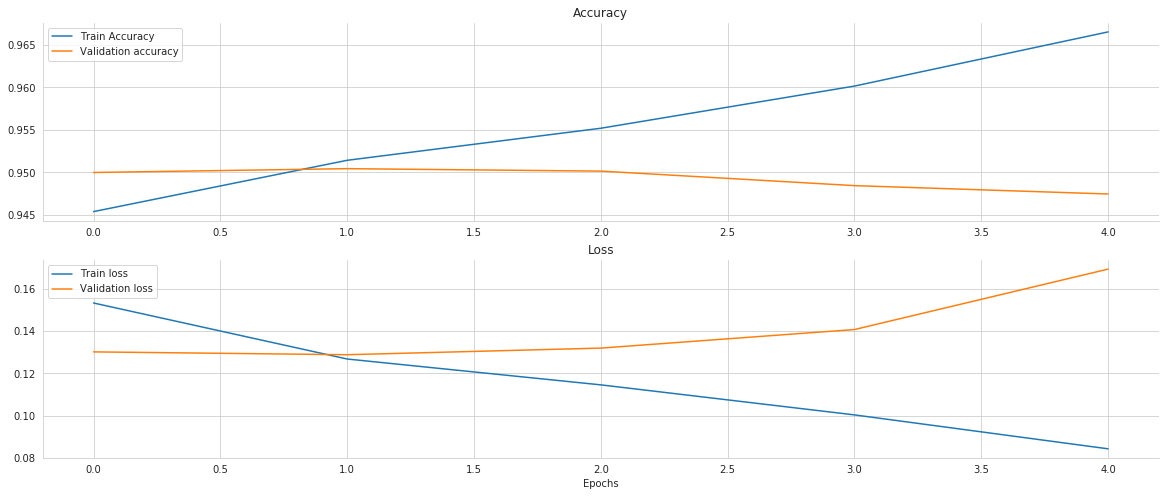

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))

ax1.plot(history.history['acc'], label='Train Accuracy')
ax1.plot(history.history['val_acc'], label='Validation accuracy')
ax1.legend(loc='best')
ax1.set_title('Accuracy')

ax2.plot(history.history['loss'], label='Train loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('Loss')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model evaluation

In [12]:
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset, subgroups, model, label_col, include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

# validate_df = pd.merge(val_ids.to_frame(), train)
validate_df['preds'] = model.predict(X_val)
validate_df = convert_dataframe_to_bool(validate_df)

bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns, 'preds', 'target')
print('Validation bias metric by group')
display(bias_metrics_df)

Validation bias metric by group


,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.9436,0.8104,homosexual_gay_or_lesbian,0.7862,2161
6,0.9522,0.7874,black,0.7926,2952
7,0.9537,0.7924,white,0.8022,5065
5,0.9411,0.8225,muslim,0.8128,4181
4,0.9323,0.8538,jewish,0.8357,1521
8,0.9536,0.8627,psychiatric_or_mental_illness,0.8797,1011
1,0.9412,0.8923,female,0.8890,10649
3,0.9212,0.9182,christian,0.8928,8065
0,0.9503,0.8851,male,0.8968,8848


In [13]:
def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

# train_df = pd.merge(train_ids.to_frame(), train)
train_df['preds'] = model.predict(X_train)
train_df = convert_dataframe_to_bool(train_df)

print('Train ROC AUC: %.4f' % get_final_metric(bias_metrics_df, metrics.roc_auc_score(train_df['target'].values, train_df['preds'].values)))
print('Validation ROC AUC: %.4f' % get_final_metric(bias_metrics_df, metrics.roc_auc_score(validate_df['target'].values, validate_df['preds'].values)))

Train ROC AUC: 0.9031
Validation ROC AUC: 0.8895


# Predictions

In [14]:
Y_test = model.predict(X_test)

In [15]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['prediction'] = Y_test
submission.to_csv('submission.csv', index=False)
submission.head(10)

,id,prediction
0,7000000,0.0001
1,7000001,0.0001
2,7000002,0.0000
3,7000003,0.0000
4,7000004,0.9748
5,7000005,0.0000
6,7000006,0.0000
7,7000007,0.0000
8,7000008,0.0018
9,7000009,0.0005
